# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [110]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x$") 
    plt.ylabel("$y$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0*x**2 - 2.0*x*y+3.0*y**2-0.8

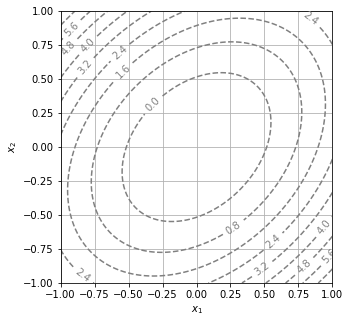

In [105]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

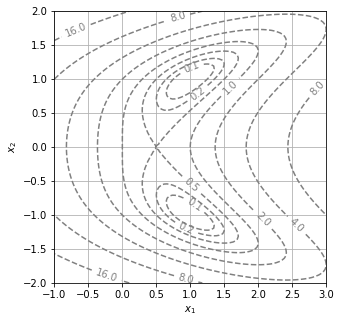

In [95]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

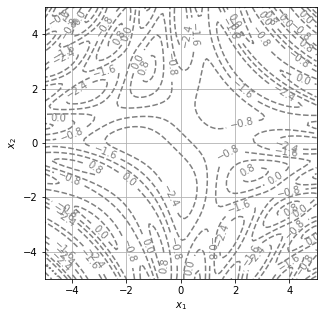

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
#La fonction demande une grande précision devant l'unité (longueur caractéristique de variation de la fonction)

N=100
eps=0.001

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [73]:
def Newton(F, x0, y0, eps = eps, N = N):
    """
    Applique la méthode de Newton pour chercher les solutions de F(x,y) = 0 où F est une fonction de R² dans R².
    La position des points est donnée à eps près, et la relation de récurrence est appliquée au plus N fois.
    """
    
    x, y = x0, y0
    J_F = J(F)
    
    for i in range(N):
        
        X = np.array([x, y])-np.linalg.inv(J_F(x, y))@F(x, y)
        x, y = X[0], X[1]
        
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
        
    else:
        raise ValueError(f"no convergence in {N} steps.")
        
#Test

F1 = lambda x, y: np.array([f1(x, y)-0.8, x-y])

Newton(F1, 0.8, 0.8)

(0.632455576338555, 0.632455576338555)

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

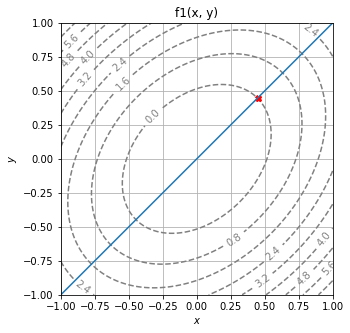

Solution trouvée à f1(x, y) = 0.0 en partant de (0.0, 0.1), suivant y = x : (0.4472135955005601, 0.4472135955005601)


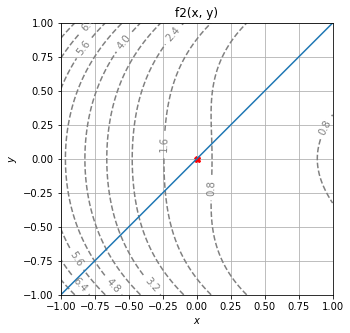

Solution trouvée à f2(x, y) = 1.0 en partant de (0.0, 0.1), suivant y = x : (-2.2144273602851296e-08, -2.2144273602851296e-08)


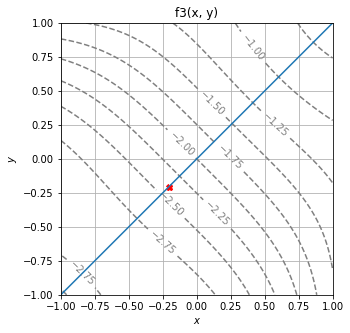

Solution trouvée à f3(x, y) = -2.4 en partant de (0.0, 0.1), suivant y = x : (-0.20629898223060325, -0.20629898223060325)


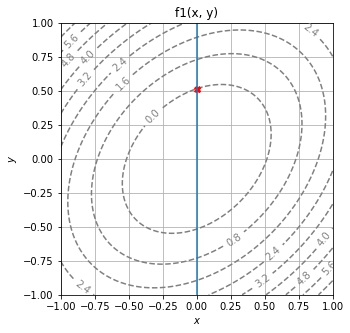

Solution trouvée à f1(x, y) = 0.0 en partant de (0.0, 0.1), suivant x = 0 : (1.2169162923454686e-21, 0.5163977795072476)


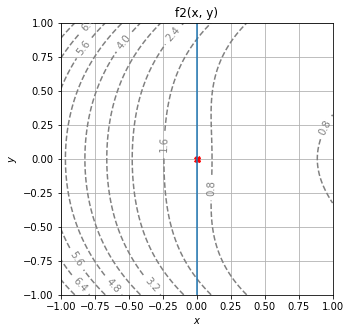

Solution trouvée à f2(x, y) = 1.0 en partant de (0.0, 0.1), suivant x = 0 : (0.0, 0.002375726355982589)


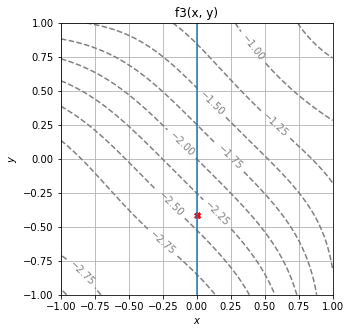

Solution trouvée à f3(x, y) = -2.4 en partant de (0.0, 0.1), suivant x = 0 : (0.0, -0.4117017913293585)


In [117]:
for i, x in enumerate([[f1, 0.0], [f2, 1.0], [f3, -2.4]]):
    fct, valeur = x[0], x[1]
    F = lambda x, y : np.array([fct(x, y)-valeur, x-y])
    
    solution = Newton(F, 0.0, 0.1)
    display_contour(
        fct, 
        x = np.linspace(-1.0, 1.0, 100), 
        y = np.linspace(-1.0, 1.0, 100), 
        levels = 10 # 10 levels, automatically selected
    )
    plt.title(f'f{i+1}(x, y)')
    plt.plot(solution[0], solution[1], 'rX', np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    
    plt.show()
    print(f"Solution trouvée à f{i+1}(x, y) = {valeur} en partant de (0.0, 0.1), suivant y = x : {solution}")    
    
for i, x in enumerate([[f1, 0.0], [f2, 1.0], [f3, -2.4]]):
    fct, valeur = x[0], x[1]
    F = lambda x, y : np.array([fct(x, y)-valeur, x])
    
    solution = Newton(F, 0.0, 0.1)
    display_contour(
        fct, 
        x = np.linspace(-1.0, 1.0, 100), 
        y = np.linspace(-1.0, 1.0, 100), 
        levels = 10 # 10 levels, automatically selected
    )
    plt.title(f'f{i+1}(x, y)')
    plt.plot(solution[0], solution[1], 'rX', np.full(100, 0), np.linspace(-1, 1, 100))
    
    plt.show()
    print(f"Solution trouvée à f{i+1}(x, y) = {valeur} en partant de (0.0, 0.1), suivant x = 0 : {solution}")

In [118]:
plt.plot?

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [57]:
def level_curve(fct, x0, y0, delta = 0.02, N = 1000, eps = eps):
    """
    Renvoie une suite de point correspondant à une ligne brisée, approximation de la courbe de niveau f(x,y) = 0.
    La distance entre deux points successifs vaut delta, et la précision sur chaque point vaut eps.
    La ligne brisée contient au plus N points.
    """
    
    #On trouve le premier point de la courbe de niveau
    F1 = lambda x, y : np.array([fct(x, y), x-y])
    x0, y0 = Newton(F1, x0, y0)

    res = np.empty((2, N))
    res[0, 0], res[1, 0] = x0, y0
    grad_f = grad(fct)
    
    for i in range(1, N):
        gf = grad_f(x0, y0)
        gf = gf/np.linalg.norm(gf)*delta
        x, y = x0+gf[1], y0-gf[0]
        F2 = lambda x,y : np.array([fct(x, y) , np.sqrt((x-x0)**2+(y-y0)**2)-delta])
        x0, y0 = Newton(F2, x, y)
        res[0,i], res[1,i] = x0, y0
        
    return res

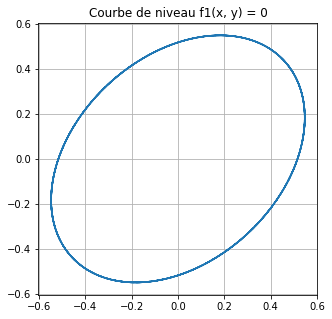

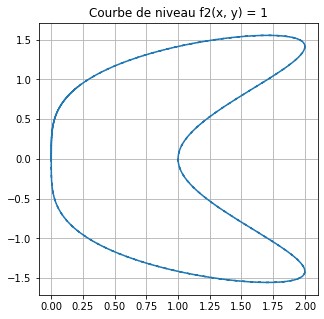

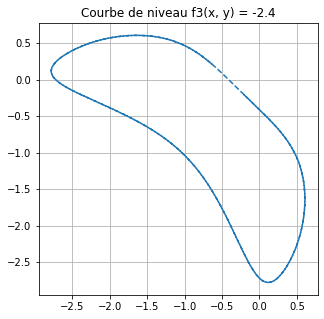

In [58]:
#Affichage des résultats

for i, x in enumerate([[f1, 0], [f2, 1],[f3, -2.4]]):
    fct, valeur = x[0], x[1]
    Fct = lambda x, y : fct(x, y)-valeur
    res = level_curve(Fct, 0.0, 0.1)
    plt.plot(res[0,::], res[1,::], ls='--')
    plt.grid()
    plt.title(f'Courbe de niveau f{i+1}(x, y) = {valeur}')
    plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [16]:
def level_curve_ss_boucle(fct, x0, y0, delta = 0.02, N = 10000, eps = eps):
    """
    Renvoie une suite de point correspondant à une ligne brisée, approximation de la courbe de niveau f(x,y) = 0,
    sans faire plusieurs fois le tour d'une même courbe de niveau.
    La distance entre deux points successifs vaut delta, et la précision sur chaque point vaut eps.
    La ligne brisée contient au plus N points.
    """
    
    #On trouve le premier point de la courbe de niveau
    F1 = lambda x,y : np.array([fct(x, y), x-y])
    x0, y0 = Newton(F1, x0, y0)

    res = np.empty((2, N))
    res[0, 0], res[1, 0] = x0, y0
    grad_f = grad(fct)
    
    for i in range(1, N):
        gf = grad_f(x0, y0)
        gf = gf/np.linalg.norm(gf)*delta
        x, y = x0+gf[1], y0-gf[0]
        F2 = lambda x, y : np.array([fct(x,y) , np.sqrt((x-x0)**2+(y-y0)**2)-delta])
        x0, y0 = Newton(F2, x, y)
        res[0,i], res[1,i] = x0, y0
        if np.sqrt((res[0,0]-res[0,i])**2+(res[1,0]-res[1,i])**2)<delta and i>1 : 
            return res[::, :i+1:]
        
    return res

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

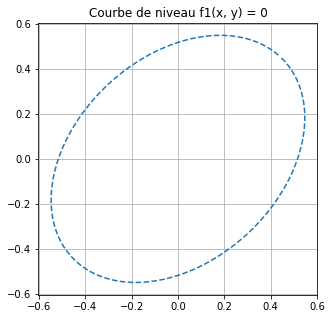

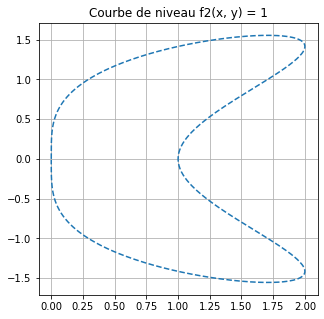

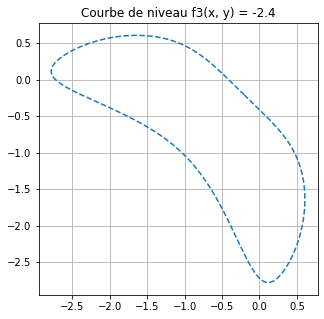

In [23]:
#Affichage des résultats

for i, x in enumerate([[f1, 0], [f2, 1],[f3, -2.4]]):
    fct, valeur = x[0], x[1]
    Fct = lambda x, y : fct(x, y)-valeur
    res = level_curve_ss_boucle(Fct, 0.0, 0.1)
    plt.plot(res[0,::], res[1,::], ls='--')
    plt.grid()
    plt.title(f'Courbe de niveau f{i+1}(x, y) = {valeur}')
    plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [178]:
def area_squares(f, c, h = 0.01):
    """
    Calcule l'aire d'une forme définie par f(x,y) <= c par la méthode des carrés.
    R² est restreint à un carré de côté arbitrairement fixé à 10 centré en (0, 0) divisé en 
    un maillage de carré élémentaire. Le résultat est la somme des aires des carrés élémentaires
    dont le centre (x, y) vérifie f(x, y) <= c
    """
    N = int(10/h)
    
    carre = np.linspace(
        (np.linspace((-5+h/2, 5-h/2), (5-h/2, 5-h/2), N)), 
        (np.linspace((-5+h/2, -5+h/2), (5-h/2, -5+h/2), N)), 
        N
    )
    
    nb_cell = 0
    
    #On parcourt tous les centres des carrés élémentaires et on regarde s'ils sont dans la forme f(x,y) <= c
    for x in carre:
        for y in x :
            if f(y[0], y[1]) <= c:
                nb_cell += 1
    
    return(nb_cell*h**2)

In [181]:
#Construction du tableau des valeurs de précision du maillage de R², en échelle log

H = np.linspace(np.log(0.005), 0, 100)
H = np.exp(H)
A = np.full(len(H), np.pi)

#Définition de la fonction associée au cercle unité

cercle = lambda x,y : x**2+y**2

#Vectorisation

area_squares_vect = np.vectorize(area_squares)

#Construction des mesures par la méthode méthode des carrés pour les valeurs de h, et de l'erreur associée

Valeur = area_squares_vect(cercle, 1, H)
Erreur = np.abs(np.pi-Valeur)

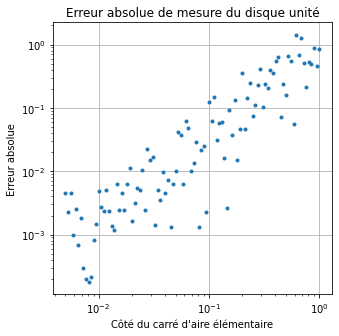

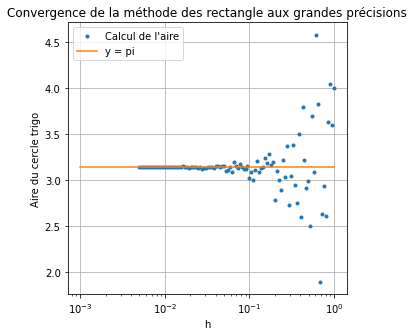

In [138]:
#Affichage du résultat en échelle log/log

plt.plot(H, Erreur, '.')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Erreur absolue')
plt.xlabel("Côté du carré d'aire élémentaire")
plt.title('Erreur absolue de mesure du disque unité')
plt.grid()
plt.show()
plt.plot(H, Valeur, '.', label = "Calcul de l'aire")
plt.plot(Delta, np.full(np.shape(Delta), np.pi), label = 'y = pi')
plt.xlabel('h')
plt.ylabel("Aire du cercle trigo")
plt.legend()
plt.xscale('log')
plt.title('Convergence de la méthode des rectangle aux grandes précisions')
plt.grid()
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [171]:
def encadrement(f, c):
    h = 1
    aire1 = 0
    
    #A partir du graphique établi ci-dessus, on sait que pour h <= 10**-2, on obtiendra bien une erreur <= 10**-2
    aire2 = area_squares(f, c, 0.01)
    print(aire2)
    diff = aire1-aire2
    while abs(diff) > 10**-2:
        aire1 = area_squares(f, c, h)
        h = 3/4*h
        diff = aire1-aire2
    return (f"L'aire de la forme cherchée est comprise en {aire1} et {aire2}")

In [188]:
encadrement(cercle, 2)

6.2784


"L'aire de la forme cherchée est comprise en 6.285137136170278 et 6.2784"

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [24]:
def B_n(delta, xp, yp):
    
    cercle1 = lambda x,y : x**2+y**2-1
    forme = level_curve_ss_boucle(cercle1, 0.0, 0.1, delta).T
    longueur = np.shape(forme)[0]
    res = 0

    for i in range(longueur):
        point, voisin = forme[i], forme[(i+1) % longueur]
        vect1, vect2 = [voisin[0]-xp, voisin[1]-yp], [point[0]-xp, point[1]-yp]

        res += (vect1[0]*vect2[1] - vect1[1]*vect2[0])/2
    
    return res

In [140]:
#Définition de la fonction associée au cercle trigonométrique et du point p

p=np.array([0,0])

#Vectorisation

B_n_vect = np.vectorize(B_n)

#Construction des tableaux associés aux différentes valeurs de précision de la ligne de niveau

Delta = np.linspace(np.log(0.001), 0, 50)
Delta = np.exp(Delta)
Aire = B_n_vect(Delta, p[0], p[1])
Erreur = np.abs(np.pi-Aire)

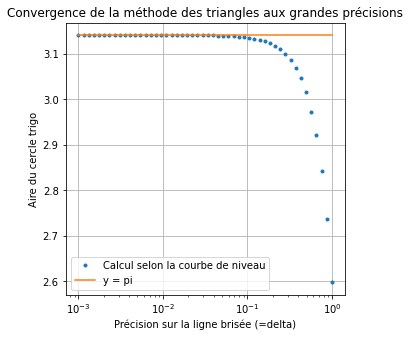

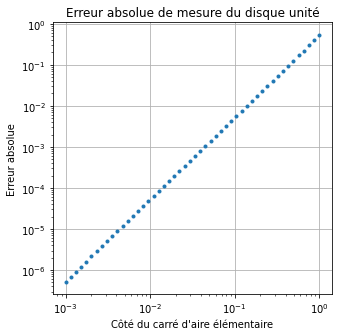

In [145]:
#Tracé des résultats

plt.plot(Delta, Aire, '.', label = "Calcul selon la courbe de niveau")
plt.plot(Delta, np.full(np.shape(Delta), np.pi), label = 'y = pi')
plt.xlabel('Précision sur la ligne brisée (=delta)')
plt.ylabel("Aire du cercle trigo")
plt.grid()
plt.xscale('log')
plt.legend()
plt.title('Convergence de la méthode des triangles aux grandes précisions')
plt.show()
plt.plot(Delta, Erreur, '.')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Erreur absolue')
plt.xlabel("Côté du carré d'aire élémentaire")
plt.title('Erreur absolue de mesure du disque unité')
plt.grid()
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [43]:
#On place le point p à l'extérieur du cercle unité

p=np.array([2, 0])
aire = B_n(0.02, p[0], p[1])
print(f"Aire du cercle unité = {aire : .6f}")
print(f"Erreur relative = {abs(np.pi-aire)/np.pi*10**2 : .6f} %")

#Le résultat obtenu est quand même le bon car les aires prises en compte à l'extérieur de la forme le sont deux fois :
#Une fois en positif, et une fois en négatif, car le déterminant associé est calculé en fois dans le sens trigo, et une
#fois dans le sens anti-trigo.


Aire du cercle unité =  3.141383
Erreur relative =  0.006661 %


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

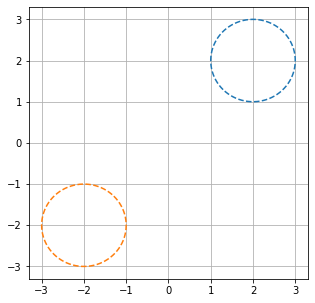

Aire de la réunion des deux disques =  6.284


In [148]:
cercle1 = lambda x, y : (x-2)**2 + (y-2)**2 - 1
cercle2 = lambda x, y : (x+2)**2 + (y+2)**2 - 1
res1 = level_curve_ss_boucle(cercle1, 0.0, 0.1, delta = 0.001)
res2 = level_curve_ss_boucle(cercle2, 0.0, 0.1, delta = 0.001)
forme = np.concatenate((res1, res2), axis =1).T
plt.plot(res1[0,::], res1[1,::], '--', res2[0,::], res2[1,::], '--')
plt.grid()
plt.show()

xp, yp = 0.0, 0.0

longueur = np.shape(forme)[0]
res = 0
    
for i in range(longueur):
    point, voisin = forme[i], forme[(i+1) % longueur]
    vect1, vect2 = [voisin[0]-xp, voisin[1]-yp], [point[0]-xp, point[1]-yp]
        
    res += (vect1[0]*vect2[1] - vect1[1]*vect2[0])/2

print(f"Aire de la réunion des deux disques = {res : .3f}")

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [46]:
def area_triangles(f, c, xp, yp, delta = 0.005):
    """Calcul de l'aire de la forme délimitée par la courbe de niveau f(x,y) = c par la méthode des triangles.
    Le résultat est égal à la somme des triangles formés par deux points successifs de la courbe de niveau
    et le point de coordonnées (xp, yp).
    La méthode ne fonctionne que pour un ensemble borné.
    """
    
    F = lambda x, y : f(x, y) - c
    forme = level_curve_ss_boucle(F, 0.0, 0.1, delta = delta)
    
    forme = forme.T
    
    longueur = np.shape(forme)[0]
    res = 0
    
    for i in range(longueur):
        point, voisin = forme[i], forme[(i+1) % longueur]
        vect1, vect2 = [voisin[0]-xp, voisin[1]-yp], [point[0]-xp, point[1]-yp]
        
        res += (vect1[0]*vect2[1] - vect1[1]*vect2[0])/2
    
    return res

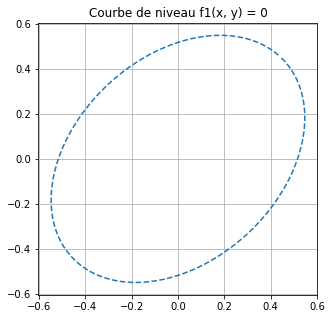

Aire délimité par f1(x,y) = 0
Méthode des carrés =  0.8898
Méthode des triangles =  0.8886
Ecart relatif =  0.1392 %


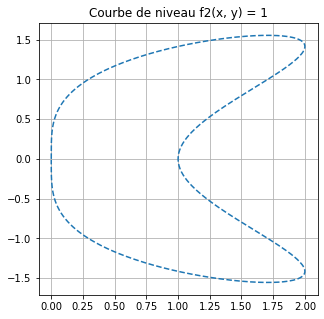

Aire délimité par f2(x,y) = 1
Méthode des carrés =  3.6720
Méthode des triangles =  3.6727
Ecart relatif =  0.0192 %


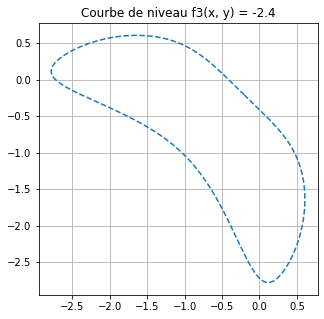

Aire délimité par f3(x,y) = -2.4
Méthode des carrés =  12.3868
Méthode des triangles =  4.6720
Ecart relatif =  165.1307 %


In [147]:
#Comparaison des résultats

for i, x in enumerate([[f1, 0], [f2, 1], [f3, -2.4]]):
    fct, valeur = x[0], x[1]
    Fct = lambda x, y : fct(x, y)-valeur
    res = level_curve_ss_boucle(Fct, 0.0, 0.1)
    plt.plot(res[0,::], res[1,::], ls='--')
    plt.grid()
    plt.title(f'Courbe de niveau f{i+1}(x, y) = {valeur}')
    plt.show()
    aire_carre = area_squares(fct, valeur)
    aire_triangle = area_triangles(fct, valeur, 1, 0)
    print(f"Aire délimité par f{i+1}(x,y) = {valeur}")
    print(f"Méthode des carrés = {aire_carre : .4f}")
    print(f"Méthode des triangles = {aire_triangle : .4f}")
    print(f"Ecart relatif = {abs(aire_carre - aire_triangle)/aire_triangle*10**2 : .4f} %")

**Comparatif**

* La méthode des carrés prend en compte tous les points tels que f(x, y) <= c, même s'ils ne sont pas à l'intérieur de la courbe de niveau, ce qui n'est pas le cas avec la méthode des triangles. Il faudrait donc idéalement connaitre les dimensions de la forme considérée.
    On explique ainsi la grosse différence du calcul de l'aire pour f3.
* Mais la méthode des carrés ne nécessite pas de calculer la courbe de niveau, et possède donc une complexité constante en O(1/h²)